# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

__Comment__

I have pushed a file 'credentials.py' into the repo with fields to enter (all fields should be strings in quotation marks) :

*Email Address For Monty email command*

email_add = your email address (hostname,portname assumes GMAIL)

email_pwd = your email password  

*API Key for Houndify to perform speech to text computation*

api_id = your houndify api id

api_key = your houndify api key

To get the email task to work, I had to allow "less-secure applications" to access my google account. When I ran the email task initially, I got a notification on my gmail which had the option to allow this.

__Code Structure__

I wrote a class called Monty, which has methods:

* record2wav : to listen on the microphone for 5 sec and writes a .wav file

* speech2txt : which feeds the .wav file into houndify and returns an ordered list of words detected by houndify

* query : which looks at the list of words and determines if the words email, calculate or joke were present in the query and calls the corresponding method

* email, math and joke which respectively carry out the tasks asked to be done in the problem

* run - this calls the above methods in order, so a user can operate monty as is given in the second cell below

```python
>>> m = Monty()
>>> m.run()
```

__Audio Instructions__

The **email** command requires the word "email", followed by the word "subject" followed by the text of the subject followed by the word "message" followed by the text of the email

The **math** command requires the input: "calculate" ::number one:: ::operator:: ::number two::, the numbers must be between zero and 20 (i.e. single words) and the possible operators are "plus", "add", "minus","subtract","times" and "over"

The **joke** command just requires the word "joke" be in the put.


In [5]:
import pyaudio, wave,time, smtplib, random
from credentials import *
from houndify_sdk import houndify
from bs4 import BeautifulSoup
from urllib.request import urlopen

# Houndify listener class
class MyListener(houndify.HoundListener):
  def onPartialTranscript(self, transcript):
    return
  def onFinalResponse(self, response):
    return
  def onError(self, err):
    print("Error: " + str(err))

class Monty():
    def __init__(self) :
        # Set up API credentials for Houndify
        self.id = api_id
        self.key = api_key
        # Default .wav file for speech2txt if not provided
        self.fname = './raw.wav'
        self.num_dict = {'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9,'ten':10,
                         'eleven':11, 'twelve':12, 'thirteen':13,'fourteen':14,'fifteen':15,'sixteen':16,'seventeen':17,
                         'eighteen':18, 'nineteen':19, 'twenty': 20, 'zero':0}
        # Set up email account and password for use of monty sending an email
        self.email_add = email_add
        self.email_pwd = email_pwd
        
    def record2wav(self) :
        # Tweaked from the audio notebook from class.
        print('Monty! is listening...')
        # Access microphone and append received data
        chunk = 512
        CHANNELS = 1
        RATE = 16000
        RECORD_SECONDS = 5
        WAVE_OUTPUT_FILENAME = "raw.wav"
        p = pyaudio.PyAudio()
        stream = p.open(format = p.get_format_from_width(2),
            channels = CHANNELS,
            rate = RATE,
            input = True,
            frames_per_buffer = chunk)
        all = []
        for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
            data = stream.read(chunk)
            all.append(data)
        print("Monty! is done recording, thinking...")
        stream.close()
        p.terminate
        data = b"".join(all)
        # Write data from microphone into a .wav file called "raw.wav"
        wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(2)
        wf.setframerate(RATE)
        wf.writeframes(data)
        wf.close()
        self.fname = WAVE_OUTPUT_FILENAME
        return

    def speech2txt(self) :
        # Send .wav file to a Houndify API client and return the parsed speech to text
        client = houndify.StreamingHoundClient(self.id,self.key, "test_user")
        audio = wave.open(self.fname)
        if audio.getsampwidth() != 2:
          print("%s: wrong sample width (must be 16-bit)" % self.fname)
          print(str(audio.getsampwidth()))
        if audio.getframerate() != 8000 and audio.getframerate() != 16000:
          print("%s: unsupported sampling frequency (must be either 8 or 16 khz)" % self.fname)
        if audio.getnchannels() != 1:
          print("%s: must be single channel (mono)" % self.fname)
        client.setSampleRate(audio.getframerate())
        client.start(MyListener())
        while True:
          samples = audio.readframes(512)
          if len(samples) == 0: break
          if client.fill(samples): break
        return client.finish()
    
    def query(self) :
        # Take results of houndify query and split into a list of individual words.
        # Based on presences of words 'email', 'calculate' or 'joke', call a relevant method
        result = self.speech2txt()
        raw_string = result.get('AllResults')[0].get('RawTranscription')
        words = raw_string.split(" ")
        print('Interpreted input: '+raw_string)
        if 'email' in words : 
            print('Monty will send you an email')
            self.email(words)
        elif 'calculate' in words :
            print('Monty will do math for you')
            self.math(words)
        elif 'joke' in words :
            print('Monty will send you a joke')
            self.joke()
        else : 
            print("Your query wasn't recognized, please try again!")
            
    
    def email(self, words) :
        #Send an email with the subject line composed of words after "subject", and the body
        # of the email composed of words after "message"
        ind_s = words.index("subject")
        ind_m = words.index("message")
        #Build Message
        FROM = self.email_add
        TO = self.email_add
        SUBJECT = ' '.join(words[ind_s+1:ind_m])
        BODY = ' '.join(words[ind_m+1:])
        MSG = "\r\n".join(["From: "+FROM,"To: "+TO,"Subject: "+SUBJECT,
                           "",BODY]) 
        #initialize email server on gmail
        try:
            s = smtplib.SMTP('smtp.gmail.com:587')
            s.ehlo()
            s.starttls()
            s.login(self.email_add,self.email_pwd)
            s.sendmail(FROM,TO,MSG)
            s.close()
            print('I successfully sent an email to '+self.email_add)
        except:
            print("I couldn't send an email...")
        return
    
    def math(self, words) :
        # Input string is assumed to contain "calculate" "number" "operation" "number"
        # This math operation is carried out and printed to the screen.
        ind = words.index("calculate")
        x = self.num_dict.get(words[ind+1])
        y = self.num_dict.get(words[ind+3])
        if words[ind+2] == "add" or words[ind+2] == "plus" :
            print(str(x)+' + '+str(y)+' = '+str(x+y))
        elif words[ind+2] == "subtract" or words[ind+2]== "minus" : 
            print(str(x)+' - '+str(y)+' = '+str(x-y))
        elif words[ind+2] == "times" : 
            print(str(x)+' x '+str(y)+' = '+str(x*y))
        elif words[ind+2] == "over" :
            print(str(x)+' / '+str(y)+' = '+str(x/y))  
        else : print('Operation : '+words[ind+2]+' not recongnized')
        return
    
    def joke(self) :
        # punoftheday website is accessed, top 10 jokes of the day accessed and then one is
        # randomly selected and printed to screen.
        response = urlopen("http://www.punoftheday.com/cgi-bin/disppuns.pl?ord=F")
        html = response.read()
        response.close()
        soup = BeautifulSoup(html,"html.parser")
        cols = soup.findAll('td')
        joke_list = []
        for col in cols : 
            if col.get("colspan") == "2" : joke_list.append(col.contents[0])
        joke_ind = random.randint(0,len(joke_list))
        print("Here is a joke for you : ")
        print("")
        print(joke_list[joke_ind])
        return 
    
    def run(self) :
        print("Hello, I'm Monty! I can listen to you speak and do some actions based on what you say: ")
        print('')
        print('1 : Send an email')
        print('If you command: \'Monty, send me an email with subject <text>, body <text> \' ')
        print('I will send you an email with the text following the \'head\' as the subject, and text following')
        print('\'message\' as the content ')
        print('')
        print('2 : Do math on numbers 0-20 (addition, subtraction, division and multiplication)')
        print('If you command: \'Monty, calculate <number> <operation> <number> \' ')
        print('I will do the operation for you and print the answer.')
        print(' For operations, you have the choice of :')
        print(' Add: say \'add\' or \'plus\'')
        print(' Subtract: say \'subtract\' or \'minus\'')
        print(' Multiply: say \'times\'')
        print(' Divide: say \'over\'')
        print('')
        print('3 : Tell me a joke')
        print('Finally, if you command \' Monty, tell me a joke\' ')
        print('I will look up a joke on the internet and print it for you.')
        print('')
        input("Press Enter when you're ready to speak!")
        self.record2wav()
        self.query()
        return

In [3]:
m = Monty()
m.run()

Hello, I'm Monty! I can listen to you speak and do some actions based on what you say: 

1 : Send an email
If you command: 'Monty, send me an email with subject <text>, body <text> ' 
I will send you an email with the text following the 'head' as the subject, and text following
'message' as the content 

2 : Do math on numbers 0-20 (addition, subtraction, division and multiplication)
If you command: 'Monty, calculate <number> <operation> <number> ' 
I will do the operation for you and print the answer.
 For operations, you have the choice of :
 Add: say 'add' or 'plus'
 Subtract: say 'subtract' or 'minus'
 Multiply: say 'times'
 Divide: say 'over'

3 : Tell me a joke
Finally, if you command ' Monty, tell me a joke' 
I will look up a joke on the internet and print it for you.

Press Enter when you're ready to speak!
Monty! is listening...
Monty! is done recording, thinking...
Interpreted input: tell me a joke
Monty will send you a joke
Here is a joke for you : 
I'd tell you a chemistry 

# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

__Comment__

To work, this code requires the .aif sound files be located in './sound_files/' from the top level of this repo

Below I define all the functions I will use to pull out notes from a .aif sound file.

In [133]:
%matplotlib inline
import aifc, math, glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks_cwt 

# Populate Dict with key numbers to notes (440Hz = A4)
# http://www.sengpielaudio.com/calculator-notenames.htm
N = 88 # Number of keys on a standard piano
octv = ['A','As','B','C','Cs','D','Ds','E','F','Fs','G','Gs']
note_dict = {}
note_dict_rev = {}
for i in range(N) :
    octave = int((i+9)/12) 
    note = octv[i - octave*12]
    note_dict.update({i+1:note+str(octave)})
    note_dict_rev.update({note+str(octave):i+1})

# Function to produce piano key number from given frequency in Hz
def freq2n(f_Hz) :
    # https://en.wikipedia.org/wiki/Piano_key_frequencies
    return 49 + int(round(12 * math.log(f_Hz/440,2)))

# Function which opens a .aif file, pulls out the time series from the bytestring
# performs an FFT and returns the spectrum and frequencies in Hz
def get_spec(fname) :
    audio = aifc.open(fname)
    nchannels = audio.getnchannels()
    sampwidth = audio.getsampwidth()
    framerate = audio.getframerate()
    nframes   = audio.getnframes()
    audio_arr = np.fromstring(audio.readframes(int(nframes)),np.int32).byteswap()
    #Combine Channels
    audio_arr_ch1 = audio_arr[::2]
    audio_arr_ch2 = audio_arr[1::2]
    audio_arr = audio_arr_ch1 + audio_arr_ch2
    audio_spec = np.abs(np.fft.rfft(audio_arr))
    # For frame time cadence should use 2/framerate because every other
    # frame switches channel.
    freqs = np.fft.rfftfreq(audio_arr.size,2/framerate)
    # Remove any f=0 signal from spectra
    return freqs[100:],audio_spec[100:]

        
# Convert each peak frequency into a note
def get_notes(freqs,spectrum,alpha=0.5) :
    peak_candidate_indices = np.where(spectrum >= alpha*max(spectrum))
    peak_candidates = freqs[peak_candidate_indices]
    notes = []
    for f in peak_candidates : 
        n = freq2n(f)
        if n >= 1 : notes.append(note_dict.get(n)) 
    # Remove repeats by converting to set and back
    notes = list(set(notes))
    # Search list of notes and remove harmonics, and repeats
    for note in notes : 
        n = note_dict_rev.get(note)
        if note_dict.get(n+12) in notes : notes = [x for x in notes if x != note_dict.get(n+12)]
    return notes

__Comment__

Now I step through one of the test organ files with known notes to show how this works.

Text(0.5,1,'./sound_files/C4+A4_PopOrgan.aif')

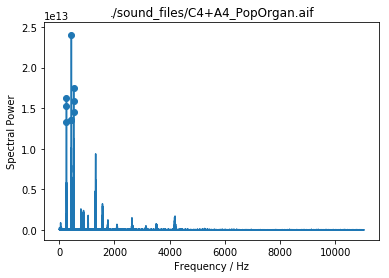

In [121]:
# Choose the C4+A4 file.
fname = './sound_files/C4+A4_PopOrgan.aif'
# Read in the file, convert to numpy arrays
# f is the list of frequency values
# s is the list of spectrum values at the corresponding frequency
f,s = get_spec(fname)
# To identify peaks, I threshold the spectrum at some fraction of the peak value
# and keep only date points above these thresholds which tend to be narrowly
# clustered on the peaks (i.e. they all give the same note)
alpha = 0.5
ind_thresh = np.where(s >= alpha*max(s))
f_filt = f[ind_thresh]
s_filt = s[ind_thresh]
# Plot the spectrum and thresholded data points to illustrate the clustering
plt.plot(f,s)
plt.scatter(f_filt,s_filt)
plt.xlabel('Frequency / Hz')
plt.ylabel('Spectral Power')
plt.title(fname)

In [123]:
# The following steps are implemented within get_notes() above

# This filtered list of frequencies is then converted to notes:
notes = []
for freq in f_filt : notes.append(note_dict.get(freq2n(freq)))
print('Notes in filtered data :')
print(notes)
print()

# Repeats are removed by calling a set
notes = list(set(notes))
print('Unique Notes :')
print(notes)
print()

# Harmonics are removed by removing notes_dict entries which are 12 keys apart
for note in notes : 
        n = note_dict_rev.get(note)
        if note_dict.get(n+12) in notes : notes = [x for x in notes if x != note_dict.get(n+12)]
print('Fundamental Notes :')
print(notes)
            

Notes in filtered data :
['C4', 'C4', 'C4', 'A4', 'A4', 'A4', 'C5', 'C5', 'C5']

Unique Notes :
['C4', 'A4', 'C5']

Fundamental Notes :
['C4', 'A4']


Now loop through the test files to check agreement

In [120]:
test_fnames = glob.glob('./sound_files/*Organ.aif')

for fname in test_fnames :
    f,s = get_spec(fname)
    notes = get_notes(f,s)
    print('For test file : '+fname+' the fundamental distinct notes played are :')
    print(notes)
    print()

For test file : ./sound_files/C4+A4_PopOrgan.aif the fundamental distinct notes played are :
['C4', 'A4']

For test file : ./sound_files/A4_PopOrgan.aif the fundamental distinct notes played are :
['A4']

For test file : ./sound_files/F4_CathedralOrgan.aif the fundamental distinct notes played are :
['F5']

For test file : ./sound_files/F3_PopOrgan.aif the fundamental distinct notes played are :
['C5', 'F3']



We see this works for the first two correctly, for the last one it picks up the correct fundamental and has also found another resonating note not listed in the test aname.

For the third entry, we have picked up the first harmonic rather than the fundamental. We can examine this entry more closely. We find we have to lower the threshold to pick up the fundamental (left most peak) which is very weak.

Text(0.5,1,'./sound_files/F4_CathedralOrgan.aif')

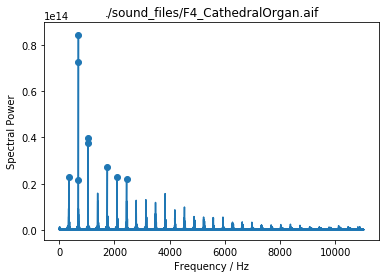

In [128]:
# Choose the F4 file.
fname = './sound_files/F4_CathedralOrgan.aif'
# Read in the file, convert to numpy arrays
# f is the list of frequency values
# s is the list of spectrum values at the corresponding frequency
f,s = get_spec(fname)
# To identify peaks, I threshold the spectrum at some fraction of the peak value
# and keep only date points above these thresholds which tend to be narrowly
# clustered on the peaks (i.e. they all give the same note)
alpha = 0.25
ind_thresh = np.where(s >= alpha*max(s))
f_filt = f[ind_thresh]
s_filt = s[ind_thresh]
# Plot the spectrum and thresholded data points to illustrate the clustering
plt.plot(f,s)
plt.scatter(f_filt,s_filt)
plt.xlabel('Frequency / Hz')
plt.ylabel('Spectral Power')
plt.title(fname)

Analyzing these notes : 

In [129]:
# The following steps are implemented within get_notes() above

# This filtered list of frequencies is then converted to notes:
notes = []
for freq in f_filt : notes.append(note_dict.get(freq2n(freq)))
print('Notes in filtered data :')
print(notes)
print()

# Repeats are removed by calling a set
notes = list(set(notes))
print('Unique Notes :')
print(notes)
print()

# Harmonics are removed by removing notes_dict entries which are 12 keys apart
for note in notes : 
        n = note_dict_rev.get(note)
        if note_dict.get(n+12) in notes : notes = [x for x in notes if x != note_dict.get(n+12)]
print('Fundamental Notes :')
print(notes)

Notes in filtered data :
['F4', 'F5', 'F5', 'F5', 'C6', 'C6', 'A6', 'C7', 'Ds7']

Unique Notes :
['F5', 'F4', 'C7', 'Ds7', 'A6', 'C6']

Fundamental Notes :
['F4', 'Ds7', 'A6', 'C6']


We now correctly pick up the F4 fundamental, but at this strength, other resonating tones 'Ds7', 'A6' and 'C6' are equally strong in the spectrum. I'm not sure what the correct thing to do here is computationally, I think the safest thing to do is to leave the threshold high, although this example shows this leaves the possibility of misidentifying the fundamental. 

Now loop through the remaining audio files which don't already have notes assigned and get the results. Since we are told there are only 3 notes played in each spectrum, I will hardcode a stipulation that if the number of notes picked up is greater than 5, get_notes should be repeated with a stricter threshold limit.

In [134]:
unknown_fnames = glob.glob('./sound_files/*.aif') 
fnames = glob.glob('./sound_files/*Organ.aif')
unknown_fnames = [x for x in unknown_fnames if x not in fnames]

for fname in unknown_fnames :
    f,s = get_spec(fname)
    notes = get_notes(f,s)
    if len(notes) > 3 : notes = get_notes(f,s,alpha=0.75)
    print('For test file : '+fname+' the fundamental distinct notes played are :')
    print(notes)
    print()

For test file : ./sound_files/8.aif the fundamental distinct notes played are :
['F4']

For test file : ./sound_files/6.aif the fundamental distinct notes played are :
['G6', 'C5']

For test file : ./sound_files/12.aif the fundamental distinct notes played are :
['C4', 'C2', 'As4']

For test file : ./sound_files/2.aif the fundamental distinct notes played are :
['C5', 'F3']

For test file : ./sound_files/3.aif the fundamental distinct notes played are :
['A4', 'E6']

For test file : ./sound_files/11.aif the fundamental distinct notes played are :
['E2']

For test file : ./sound_files/9.aif the fundamental distinct notes played are :
['G3']

For test file : ./sound_files/5.aif the fundamental distinct notes played are :
['G2', 'D3']

For test file : ./sound_files/10.aif the fundamental distinct notes played are :
['C2', 'G3']

For test file : ./sound_files/1.aif the fundamental distinct notes played are :
['D4', 'C4', 'G4']

For test file : ./sound_files/7.aif the fundamental distinct n